In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import string
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler

import demoji

# Data Import

In [2]:
df_train_raw = pd.read_excel('Project Corpora/train.xlsx')

In [3]:
df_train_raw.head(5)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


# Exploratory Analysis

In [4]:
df_train_raw.shape

(12496, 4)

In [5]:
# Count the number of empty values in each column
empty_counts = df_train_raw.isna().sum()
print(empty_counts) 

index          0
description    0
host_about     0
unlisted       0
dtype: int64


In [6]:
df_train_raw['unlisted'].value_counts()

unlisted
0    9033
1    3463
Name: count, dtype: int64

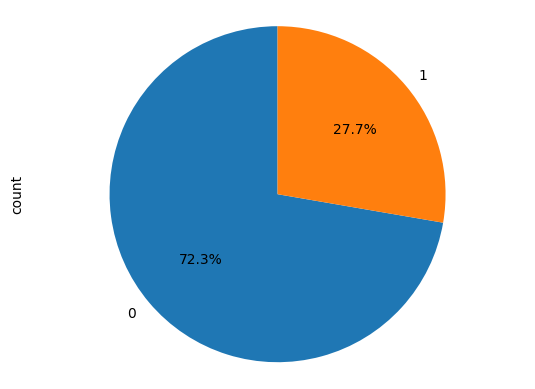

In [7]:
#df_train['unlisted'].pie()  # Classes are imbalanced !!!
# plot a pie chart for the 'count' column
df_train_raw['unlisted'].value_counts().plot(kind='pie', 
                                             labels=df_train_raw['unlisted'].unique(), 
                                             autopct='%1.1f%%', 
                                             startangle=90)
plt.axis('equal')
plt.show()

In [8]:
df_train_raw['description'].str.len().describe()

count    12496.000000
mean       814.679097
std        282.124598
min         12.000000
25%        625.000000
50%       1000.000000
75%       1000.000000
max       1000.000000
Name: description, dtype: float64

In [9]:
df_train_raw['host_about'].str.len().describe()

count    12496.000000
mean       439.562100
std        486.270567
min          1.000000
25%        152.000000
50%        325.000000
75%        612.000000
max       8683.000000
Name: host_about, dtype: float64

# Preprocesssing

In [10]:
df = pd.read_csv('output/train_with_translation.csv') # this is the result of translation of descriptions
df.head(5)

,index,description,host_about,unlisted,description_language,host_about_language,description_english
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"This is a shared mixed room in our hostel, wit..."
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,"My space is close to Parque Eduardo VII, Salda..."
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,Trafaria’s House is a cozy and familiar villa ...
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!\nI m Portuguese and i love to meet peop...,0,pt,en,"Charming apartment in Chiado, Between the Farg..."
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,Beautiful apartment on the beach.<br /> 2 min....


## Splitting data into Train and Validation

In [96]:
# Split the original train dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, 
                                    stratify=df['unlisted']) # using stratify, to keep classes proportion

print('Shapes of train_df', train_df.shape)
print('Shapes of val_df', val_df.shape)

Shapes of train_df (9996, 7)
Shapes of val_df (2500, 7)


## Word Count

In [12]:
train_df[905:910]

,index,description,host_about,unlisted,description_language,host_about_language,description_english
5963,5964,O apartamento está localizado numa zona muito ...,"I was born in Lisbon, live here and I love thi...",0,pt,en,The apartment is located in a very quiet and p...
8624,8625,<b>Other things to note</b><br />About the Hos...,Sant Jordi Hostels Lisbon is a chic designer h...,0,en,en,<b>Other things to note</b><br />About the Hos...
9231,9232,We have 10 luxury serviced-apartments all unde...,Martinhal Chiado in the old town in Lisbon is ...,0,en,en,We have 10 luxury serviced-apartments all unde...
3396,3397,"Apartamento ideal para 2 pessoas, com possibil...",What makes us fall in love every day in the ci...,0,pt,en,"Ideal apartment for 2 people, with the possibi..."
9671,9672,Situated in Alfama - the oldest and most typic...,"We are Elsa and Rui, computer engineers and en...",0,en,en,Situated in Alfama - the oldest and most typic...


In [13]:
# Fetch wordcount for each abstract
train_df['word_count']  = train_df['description'].apply(lambda x: len(str(x).split(" ")))
#train_df[['description','word_count']].head()
train_df.head()

,index,description,host_about,unlisted,description_language,host_about_language,description_english,word_count
7712,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",167
11333,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",167
3536,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,175
4061,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0,en,en,Nice studio for two people with one bathroom a...,164
2742,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0,en,en,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...",170


### Descriptive Statistics of word count

In [14]:
train_df.word_count.describe()

count    9996.000000
mean      132.795018
std        48.323208
min         3.000000
25%        99.000000
50%       157.000000
75%       167.000000
max       210.000000
Name: word_count, dtype: float64

<Axes: >

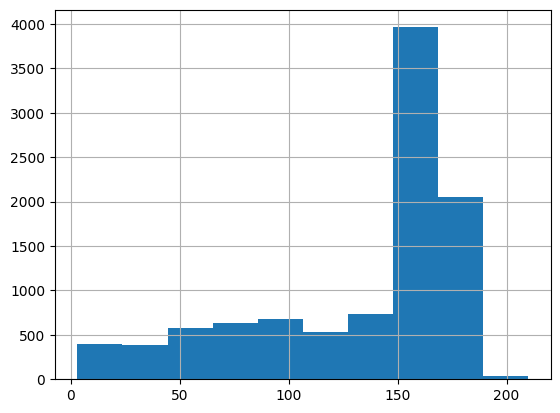

In [15]:
train_df['word_count'].hist()

In [16]:
all_words = ' '.join(train_df['description']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

the      50115
and      43918
a        40453
/><br    27999
to       24560
of       24049
in       22402
with     21558
is       19192
de       11009
Name: count, dtype: int64

In [17]:
freq.index[0:10]

Index(['the', 'and', 'a', '/><br', 'to', 'of', 'in', 'with', 'is', 'de'], dtype='object')

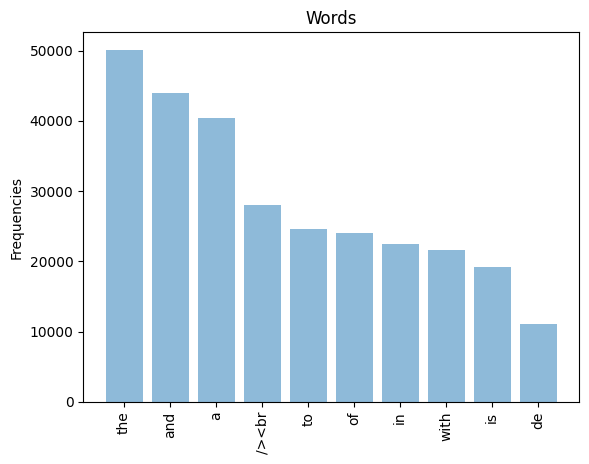

In [18]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
#plt.xticks(values, x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

## Preprocessing: cleaning, stemming, lemmatization

In [19]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [20]:
def clean(text_list, lemmatize, stemmer):   
    cleaned_text_list = []  
    text_list.fillna('', inplace=True)
    for text in tqdm(text_list):           
        #LOWERCASE TEXT
        text = text.lower()
        
        #Converting emoji to their description
        text = demoji.replace_with_desc(text)

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])

        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        #Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())

        cleaned_text_list.append(text)        
    return cleaned_text_list

In [21]:
cleaned_text_list = clean(train_df['description_english'], lemmatize = True, stemmer = False)

100%|██████████████████████████████████████| 9996/9996 [00:23<00:00, 420.19it/s]


In [22]:
train_df['cleaned_description'] = cleaned_text_list
train_df.head(3)

,index,description,host_about,unlisted,description_language,host_about_language,description_english,word_count,cleaned_description
7712,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",167,exclusive villa located quiet pinewood area co...
11333,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",167,luna house b b part luna house hub located clo...
3536,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,175,newly refurbished apartment swimming pool stun...


In [23]:
#def update_df(dataframe, list_updated):
#    dataframe.update(pd.DataFrame({"description": list_updated}))
    
#x_train = x_train.drop(['word_count'], axis=1)
#update_df(x_train, updates)
#x_train

# Defining training features

## Bag of Words (Bow)
Each word is a feature. Our feature space is defined by our vocabulary. Documents/pieces of text will be represented as sparse vectors.

In [24]:
bow = CountVectorizer(binary=True)
x_train = bow.fit_transform(train_df["cleaned_description"])
x_train

<9996x15179 sparse matrix of type '<class 'numpy.int64'>'
	with 568037 stored elements in Compressed Sparse Row format>

In [25]:
# To see the content of the built x_train matrix
print(x_train.toarray()[:5])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [26]:
feature_names = bow.get_feature_names_out()
print(feature_names[:50])

['aa' 'aais' 'aas' 'aasper' 'ab' 'aba' 'abaixo' 'abandoned' 'abelhas'
 'abelheira' 'aberta' 'aberto' 'abeviated' 'abide' 'ability' 'able' 'ably'
 'abnb' 'aboard' 'abode' 'abou' 'abound' 'absence' 'absense' 'absolute'
 'absolutely' 'absolutly' 'absorb' 'absorbing' 'absorve' 'abstract'
 'abundance' 'abundant' 'abundantly' 'abuse' 'abuts' 'ac' 'acaba'
 'acabamentos' 'acabou' 'acacia' 'academic' 'academy' 'acapulco' 'acc'
 'acce' 'accent' 'accented' 'accentuated' 'accentuating']


In [27]:
y_train = train_df['unlisted']

# Train Classifier

In [28]:
modelknn = KNeighborsClassifier(n_neighbors = 7, 
                                metric = 'cosine', 
                                weights = 'distance')

In [29]:
modelknn.fit(x_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7, weights='distance')

# Predict for Val corpus

In [30]:
#update_df(x_val, clean(x_val['description'], lemmatize = True, stemmer = False))

In [31]:
val_df

,index,description,host_about,unlisted,description_language,host_about_language,description_english
4768,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,en,en,This charming apartment on the first floor of ...
4384,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,en,en,Charming villa with a private pool and tennis ...
11857,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,en,en,One bedroom apartment inside a modern developm...
1281,1282,"Apartment in the heart of the city, between Pr...","Hi!\n\nI'm Laura, I'm 32yo, and I live with my...",0,en,en,"Apartment in the heart of the city, between Pr..."
2133,2134,Amazing flat with two bedrooms in Restauradore...,We are Feels Like Home Holiday Rentals.\nA com...,0,en,en,Amazing flat with two bedrooms in Restauradore...
...,...,...,...,...,...,...,...
2648,2649,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0,en,en,"Set in a stunning seaside location, this luxur..."
9002,9003,The apartment in Lisbon has 2 bedrooms and has...,We are Feels Like Home Holiday Rentals.\nA com...,0,en,en,The apartment in Lisbon has 2 bedrooms and has...
8678,8679,"Junto ao Palácio de S. Bento, e á assembleia d...","Olá sou o João, e estou á vossa espera para lh...",0,pt,pt,"Together with the Palácio de S. Bento, and the..."
5770,5771,"The apartment is very homely, and it was thoug...",Hi there! We are The Mojo Team (MCPP Investme...,0,en,en,"The apartment is very homely, and it was thoug..."


In [32]:
val_df['cleaned_description'] = clean(val_df['description_english'], lemmatize = True, stemmer = False)
val_df.head()

100%|██████████████████████████████████████| 2500/2500 [00:05<00:00, 428.53it/s]


,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description
4768,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,en,en,This charming apartment on the first floor of ...,charming apartment first floor typical cascais...
4384,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,en,en,Charming villa with a private pool and tennis ...,charming villa private pool tennis table withi...
11857,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,en,en,One bedroom apartment inside a modern developm...,one bedroom apartment inside modern developmen...
1281,1282,"Apartment in the heart of the city, between Pr...","Hi!\n\nI'm Laura, I'm 32yo, and I live with my...",0,en,en,"Apartment in the heart of the city, between Pr...",apartment heart city pr ncipe real chiado bair...
2133,2134,Amazing flat with two bedrooms in Restauradore...,We are Feels Like Home Holiday Rentals.\nA com...,0,en,en,Amazing flat with two bedrooms in Restauradore...,amazing flat two bedroom restauradores lisbon ...


In [33]:
X_val = bow.transform(val_df['cleaned_description'])
y_val = np.array(val_df['unlisted'])

#X = df_train[['description']]
#y = df_train['unlisted']

In [34]:
y_pred = modelknn.predict(X_val)

# Evaluate

In [35]:
labels = {"listed":0, "unlisted":1}
print(classification_report(y_pred, y_val, target_names = labels.keys()))

              precision    recall  f1-score   support

      listed       0.91      0.81      0.86      2027
    unlisted       0.45      0.66      0.53       473

    accuracy                           0.78      2500
   macro avg       0.68      0.73      0.69      2500
weighted avg       0.82      0.78      0.80      2500



In [36]:
confusion_matrix(y_pred, y_val)

array([[1644,  383],
       [ 163,  310]])

In [37]:
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    #plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    #plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

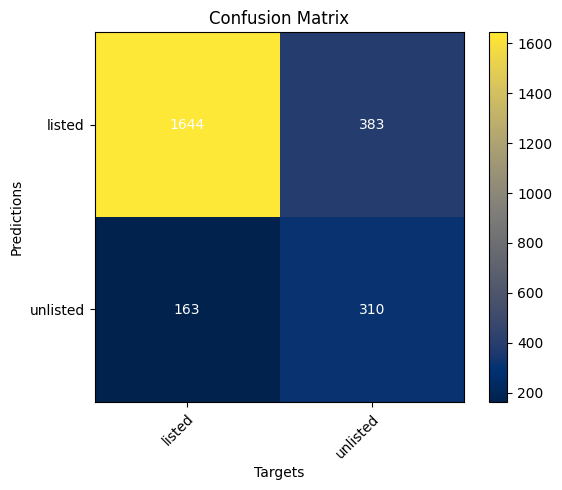

In [38]:
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

# Extending Features with Reviews

## Preprocessing Reviews

In [39]:
train_df.head(3)

,index,description,host_about,unlisted,description_language,host_about_language,description_english,word_count,cleaned_description
7712,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",167,exclusive villa located quiet pinewood area co...
11333,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",167,luna house b b part luna house hub located clo...
3536,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,175,newly refurbished apartment swimming pool stun...


In [40]:
reviews_df = pd.read_csv('output/train_reviews_with_sentiment.csv')
reviews_df.iloc[1000:1110, :]

,index,comments,language,comments_no_emoji,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
1000,23,"A well equipt, clean unit in an ideal location...",en,"A well equipt, clean unit in an ideal location...",0.439259,0.9728,0.999660
1001,23,Great place!,en,Great place!,1.000000,0.6588,0.999874
1002,23,Joao and his colleagues are all very kind and ...,en,Joao and his colleagues are all very kind and ...,0.230000,0.8104,0.996105
1003,23,L'appartement est très bien. L'agence est top ...,fr,L'appartement est très bien. L'agence est top ...,0.500000,0.2023,-0.562166
1004,23,1ère visite de Lisbonne: le logement est situé...,fr,1ère visite de Lisbonne: le logement est situé...,0.000000,0.0000,-0.933873
...,...,...,...,...,...,...,...
1105,24,"Newly, well located, fully equipped and clean ...",en,"Newly, well located, fully equipped and clean ...",0.312338,0.8874,0.999831
1106,24,"Very nice place! Great location, very helpful ...",en,"Very nice place! Great location, very helpful ...",0.626429,0.9722,0.999863
1107,24,The appartement was pretty and of good taste o...,en,The appartement was pretty and of good taste o...,0.322083,0.8781,0.999762
1108,24,Wonderful little apartment in a beautiful city!,en,Wonderful little apartment in a beautiful city!,0.604167,0.8238,0.999893


In [41]:
reviews_df['comments'] = reviews_df['comments_no_emoji'].astype('string')
reviews_df = reviews_df.dropna()

grouped = reviews_df.groupby(['index', 'language']).agg({'comments': 'count'})
grouped = grouped.reset_index()
final_grouped = grouped.groupby('index').agg({'language': 'nunique', 'comments': 'sum'})
final_grouped = final_grouped.reset_index()

# rename the columns to the desired names
final_grouped.columns = ['index', 'unique_languages_count', 'total_comments_count']
final_grouped

,index,unique_languages_count,total_comments_count
0,1,7,50
1,5,6,41
2,8,8,168
3,9,6,32
4,10,3,13
...,...,...,...
8461,12490,7,32
8462,12491,4,10
8463,12492,9,312
8464,12493,5,35


In [42]:
reviews_df_eng = reviews_df[(reviews_df['language']=='en')]

grouped_eng = reviews_df_eng.groupby(['index']).agg({'comments': ['count', ' '.join]})
grouped_eng.columns = ['_'.join(col).strip() for col in grouped_eng.columns.values]
grouped_eng = grouped_eng.reset_index()

# Rename the columns of the DataFrame
grouped_eng.columns = ['index', 'eng_comment_count', 'eng_reviews_merged']
grouped_eng

,index,eng_comment_count,eng_reviews_merged
0,1,30,this is a very cozy and comfortable house to s...
1,5,17,We really enjoyed staying at Sonias place. The...
2,8,145,Shani was very helpful throughout our process!...
3,9,16,Great little space; lovely hosts - clean and w...
4,10,11,"WOW, what a great stay! The spacious apartment..."
...,...,...,...
8293,12490,14,Excellent very well equiped apartment! Thank y...
8294,12491,7,I am so happy to found this accomodation near ...
8295,12492,212,We were very happy to find this place. The com...
8296,12493,27,"Nice place, nice location, easy communication!..."


In [43]:
merged_reviews = pd.merge(final_grouped, grouped_eng, on='index', how='left')
merged_reviews

,index,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged
0,1,7,50,30.0,this is a very cozy and comfortable house to s...
1,5,6,41,17.0,We really enjoyed staying at Sonias place. The...
2,8,8,168,145.0,Shani was very helpful throughout our process!...
3,9,6,32,16.0,Great little space; lovely hosts - clean and w...
4,10,3,13,11.0,"WOW, what a great stay! The spacious apartment..."
...,...,...,...,...,...
8461,12490,7,32,14.0,Excellent very well equiped apartment! Thank y...
8462,12491,4,10,7.0,I am so happy to found this accomodation near ...
8463,12492,9,312,212.0,We were very happy to find this place. The com...
8464,12493,5,35,27.0,"Nice place, nice location, easy communication!..."


In [44]:
# Group by 'index' and calculate median values for sentiments
grouped_sentiment = reviews_df.groupby('index')[
    ['sentiment_TextBlob', 'sentiment_nltk', 'sentiment_distilbert']].median().reset_index()

grouped_sentiment.head()

,index,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,0.280481,0.44905,0.992033
1,5,0.292708,0.20230,-0.597586
2,8,0.422480,0.94500,0.999798
3,9,0.298313,0.69305,0.973889
4,10,0.405238,0.91990,0.999775


In [45]:
# Creating the final features for reviews by merging with Sentiment medians
merged_reviews = pd.merge(merged_reviews, grouped_sentiment, on='index', how='left')
merged_reviews.head()

,index,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,7,50,30.0,this is a very cozy and comfortable house to s...,0.280481,0.44905,0.992033
1,5,6,41,17.0,We really enjoyed staying at Sonias place. The...,0.292708,0.20230,-0.597586
2,8,8,168,145.0,Shani was very helpful throughout our process!...,0.422480,0.94500,0.999798
3,9,6,32,16.0,Great little space; lovely hosts - clean and w...,0.298313,0.69305,0.973889
4,10,3,13,11.0,"WOW, what a great stay! The spacious apartment...",0.405238,0.91990,0.999775


In [46]:
# Merging reviews features to the train_df
train_df = pd.merge(train_df, merged_reviews, on='index', how='left')
train_df.head()

,index,description,host_about,unlisted,description_language,host_about_language,description_english,word_count,cleaned_description,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",167,exclusive villa located quiet pinewood area co...,3.0,25.0,21.0,Great house in a great location. Close to Lisb...,0.418750,0.97050,0.999820
1,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",167,luna house b b part luna house hub located clo...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,175,newly refurbished apartment swimming pool stun...,3.0,32.0,25.0,Great getaway in cascais. Gorgeous apartment a...,0.370833,0.93830,0.999775
3,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0,en,en,Nice studio for two people with one bathroom a...,164,nice studio two people one bathroom compact ki...,13.0,226.0,146.0,"The studio is very charming, comfortable, has ...",0.320539,0.79285,0.999446
4,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0,en,en,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...",170,whether shorter longer stay want offer solutio...,16.0,523.0,356.0,"I'm portuguese from Lisbon , living in Italy, ...",0.366667,0.86870,0.999623


In [47]:
train_df['eng_reviews_cleaned'] = clean(train_df['eng_reviews_merged'], lemmatize = True, stemmer = False)
train_df.head()

100%|███████████████████████████████████████| 9996/9996 [05:12<00:00, 32.00it/s]


,index,description,host_about,unlisted,description_language,host_about_language,description_english,word_count,cleaned_description,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert,eng_reviews_cleaned
0,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",167,exclusive villa located quiet pinewood area co...,3.0,25.0,21.0,Great house in a great location. Close to Lisb...,0.418750,0.97050,0.999820,great house great location close lisbon sintra...
1,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",167,luna house b b part luna house hub located clo...,NaN,NaN,NaN,,NaN,NaN,NaN,
2,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,175,newly refurbished apartment swimming pool stun...,3.0,32.0,25.0,Great getaway in cascais. Gorgeous apartment a...,0.370833,0.93830,0.999775,great getaway cascais gorgeous apartment excel...
3,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0,en,en,Nice studio for two people with one bathroom a...,164,nice studio two people one bathroom compact ki...,13.0,226.0,146.0,"The studio is very charming, comfortable, has ...",0.320539,0.79285,0.999446,studio charming comfortable everything need st...
4,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0,en,en,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...",170,whether shorter longer stay want offer solutio...,16.0,523.0,356.0,"I'm portuguese from Lisbon , living in Italy, ...",0.366667,0.86870,0.999623,portuguese lisbon living italy travel often ba...


## Creating Features 

In [56]:
non_text_cols = ['description_language', 'host_about_language',
                'unique_languages_count', 'total_comments_count', 'eng_comment_count',
                'sentiment_TextBlob', 'sentiment_nltk', 'sentiment_distilbert']

train_features_df = train_df[non_text_cols].copy()

train_features_df.head()

,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,en,en,3.0,25.0,21.0,0.418750,0.97050,0.999820
1,en,en,NaN,NaN,NaN,NaN,NaN,NaN
2,en,en,3.0,32.0,25.0,0.370833,0.93830,0.999775
3,en,en,13.0,226.0,146.0,0.320539,0.79285,0.999446
4,en,en,16.0,523.0,356.0,0.366667,0.86870,0.999623


In [57]:
# Replace 'en' with 1 and others with 0 in 'description_language' and 'host_about_language'
train_features_df['description_language'] = np.where(train_features_df['description_language'] == 'en', 1, 0)
train_features_df['host_about_language'] = np.where(train_features_df['host_about_language'] == 'en', 1, 0)

train_features_df.head()

,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,1,3.0,25.0,21.0,0.418750,0.97050,0.999820
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,3.0,32.0,25.0,0.370833,0.93830,0.999775
3,1,1,13.0,226.0,146.0,0.320539,0.79285,0.999446
4,1,1,16.0,523.0,356.0,0.366667,0.86870,0.999623


In [58]:
# Scaling selected columns with MinMaxScaler
scaler = MinMaxScaler()
cols_to_scale = ['unique_languages_count', 'total_comments_count', 'eng_comment_count']
train_features_df[cols_to_scale] = scaler.fit_transform(train_features_df[cols_to_scale])

train_features_df.head()

,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,1,0.071429,0.026846,0.030303,0.418750,0.97050,0.999820
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,0.071429,0.034676,0.036364,0.370833,0.93830,0.999775
3,1,1,0.428571,0.251678,0.219697,0.320539,0.79285,0.999446
4,1,1,0.535714,0.583893,0.537879,0.366667,0.86870,0.999623


### BoW

In [59]:
#bow = CountVectorizer(binary=True)
#X_train = bow.fit_transform(train_df["cleaned_description"] + ' ' + train_df["eng_reviews_cleaned"])

bow_desc = CountVectorizer(binary=True)     
bow_reviews = CountVectorizer(binary=True, max_features=1000) 

X_train_1 = bow_desc.fit_transform(train_df["cleaned_description"])
X_train_2 = bow_reviews.fit_transform(train_df["eng_reviews_cleaned"]) 

print(X_train_1.shape, X_train_2.shape)

(9996, 15179) (9996, 1000)


In [91]:
n1 = X_train_1.shape[1]
n2 = X_train_2.shape[1]
n_additional = len(non_text_cols)

X_train_ext = np.zeros((X_train_1.shape[0], n1 + n2 + n_additional))

In [92]:
X_train_ext[:, :n1] = X_train_1.toarray()       # copy over BoW for cleaned AirBnb description
X_train_ext[:, n1:n1+n2] = X_train_2.toarray()     # copy over BoW for cleaned English reviews
X_train_ext[:, n1+n2:] = train_features_df.values     # copy over the rest of features from train_features_df

X_train_ext = np.nan_to_num(X_train_ext, nan=0) # filling in empty values with zeroes

In [93]:
X_train_ext.shape

(9996, 16187)

### Processing validation set in the same manner

In [97]:
val_df.head(3)

,index,description,host_about,unlisted,description_language,host_about_language,description_english
4768,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,en,en,This charming apartment on the first floor of ...
4384,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,en,en,Charming villa with a private pool and tennis ...
11857,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,en,en,One bedroom apartment inside a modern developm...


In [98]:
val_df['cleaned_description'] = clean(val_df['description'], lemmatize = True, stemmer = False)
val_df = pd.merge(val_df, merged_reviews, on='index', how='left')
val_df.head()

100%|██████████████████████████████████████| 2500/2500 [00:06<00:00, 410.01it/s]


,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,en,en,This charming apartment on the first floor of ...,charming apartment first floor typical cascais...,8.0,54.0,33.0,The host canceled this reservation 233 days be...,0.327273,0.76295,0.998771
1,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,en,en,Charming villa with a private pool and tennis ...,charming villa private pool tennis table withi...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,en,en,One bedroom apartment inside a modern developm...,one bedroom apartment inside modern developmen...,10.0,141.0,106.0,"Everything is great and very convenient, the p...",0.371000,0.84490,0.999590
3,1282,"Apartment in the heart of the city, between Pr...","Hi!\n\nI'm Laura, I'm 32yo, and I live with my...",0,en,en,"Apartment in the heart of the city, between Pr...",apartment heart city pr ncipe real chiado bair...,12.0,208.0,144.0,Great apartment! Great location! Great hospita...,0.390972,0.87550,0.999710
4,2134,Amazing flat with two bedrooms in Restauradore...,We are Feels Like Home Holiday Rentals.\nA com...,0,en,en,Amazing flat with two bedrooms in Restauradore...,amazing flat two bedroom restauradores lisbon ...,10.0,34.0,21.0,"Very clean, professional and central. Would re...",0.279365,0.65285,0.998494


In [99]:
val_df['eng_reviews_cleaned'] = clean(val_df['eng_reviews_merged'], lemmatize = True, stemmer = False)

val_df.head(3)

100%|███████████████████████████████████████| 2500/2500 [01:18<00:00, 31.89it/s]


,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert,eng_reviews_cleaned
0,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,en,en,This charming apartment on the first floor of ...,charming apartment first floor typical cascais...,8.0,54.0,33.0,The host canceled this reservation 233 days be...,0.327273,0.76295,0.998771,host canceled reservation day arrival automate...
1,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,en,en,Charming villa with a private pool and tennis ...,charming villa private pool tennis table withi...,NaN,NaN,NaN,,NaN,NaN,NaN,
2,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,en,en,One bedroom apartment inside a modern developm...,one bedroom apartment inside modern developmen...,10.0,141.0,106.0,"Everything is great and very convenient, the p...",0.371000,0.84490,0.999590,everything great convenient parking place near...


In [100]:
# Processing non-textual features
val_features_df = val_df[non_text_cols].copy()
val_features_df['description_language'] = np.where(val_features_df['description_language'] == 'en', 1, 0)
val_features_df['host_about_language'] = np.where(val_features_df['host_about_language'] == 'en', 1, 0)

# Scaling
val_features_df[cols_to_scale] = scaler.transform(val_features_df[cols_to_scale])

val_features_df.head()

,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,1,0.250000,0.059284,0.048485,0.327273,0.76295,0.998771
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,0.321429,0.156600,0.159091,0.371000,0.84490,0.999590
3,1,1,0.392857,0.231544,0.216667,0.390972,0.87550,0.999710
4,1,1,0.321429,0.036913,0.030303,0.279365,0.65285,0.998494


In [101]:
X_val_1 = bow_desc.transform(val_df["cleaned_description"])
X_val_2 = bow_reviews.transform(val_df["eng_reviews_merged"])                            
n1 = X_val_1.shape[1]
n2 = X_val_2.shape[1]
n_additional = len(non_text_cols)

X_val_ext = np.zeros((X_val_1.shape[0], n1 + n2 + n_additional))
X_val_ext[:, :n1] = X_val_1.toarray()      # copy over BoW for cleaned AirBnb description
X_val_ext[:, n1:n1+n2] = X_val_2.toarray() # copy over BoW for cleaned English reviews
X_val_ext[:, n1+n2:] = val_features_df.values   # copy over the rest of features from val_features_df
X_val_ext = np.nan_to_num(X_val_ext, nan=0)   # filling in empty values with zeroes                                 

y_val = np.array(val_df['unlisted'])

print(X_val_ext.shape, y_val.shape)

(2500, 16187) (2500,)


# Building Models on the Extended List of Features

## KNN model (on extended list of features)

In [102]:
# Model Building
modelknn = KNeighborsClassifier(n_neighbors = 7, 
                                metric = 'cosine', 
                                weights = 'distance')

modelknn.fit(X_train_ext, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7, weights='distance')

In [103]:
# Making preditions
y_pred = modelknn.predict(X_val_ext)

              precision    recall  f1-score   support

      listed       0.91      0.91      0.91      1801
    unlisted       0.77      0.76      0.77       699

    accuracy                           0.87      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.87      0.87      0.87      2500



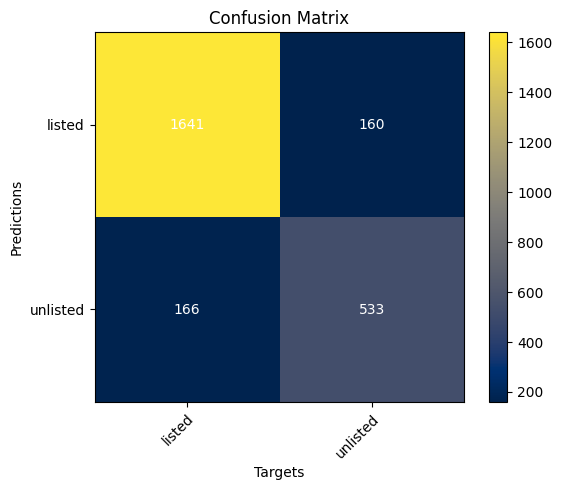

In [104]:
# Model Evaluation
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

## RandomForest (on extended list of features)

              precision    recall  f1-score   support

      listed       0.90      0.92      0.91      1764
    unlisted       0.81      0.76      0.78       736

    accuracy                           0.87      2500
   macro avg       0.85      0.84      0.85      2500
weighted avg       0.87      0.87      0.87      2500



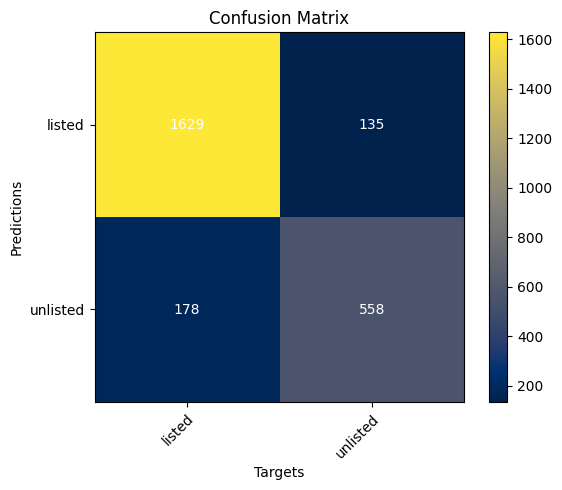

In [106]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=100, 
                                      class_weight={0: 0.7, 1: 0.3}, 
                                      random_state=42)

model_forest.fit(X_train_ext, y_train)

# Predicting
y_pred = model_forest.predict(X_val_ext)

# Evaluation
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

##  XGBoost model (on extended list of features)

XGBoost can work well with sparse and high-dimensional data, such as the bag-of-words representation used in text mining, as it has built-in support for sparse data structures. XGBoost uses a technique called "sparse-aware" gradient boosting, which is designed to handle sparse input data more efficiently than dense data.

However, when working with very large datasets, memory usage can become a concern, especially if the dataset has many features or is very sparse. In this case, you may need to consider using techniques such as feature selection or dimensionality reduction to reduce the number of features or the dimensionality of the data, or consider using distributed computing frameworks such as Apache Spark to parallelize the training process across multiple machines.

In addition to XGBoost, there are other classification models that are commonly used in text mining, such as logistic regression, support vector machines, and neural networks. The choice of model will depend on the specific characteristics of your data, the size of your dataset, and the computational resources available to you. You may need to experiment with multiple models to find the best one for your specific problem.

              precision    recall  f1-score   support

      listed       0.96      0.85      0.90      2028
    unlisted       0.56      0.83      0.67       472

    accuracy                           0.85      2500
   macro avg       0.76      0.84      0.79      2500
weighted avg       0.88      0.85      0.86      2500



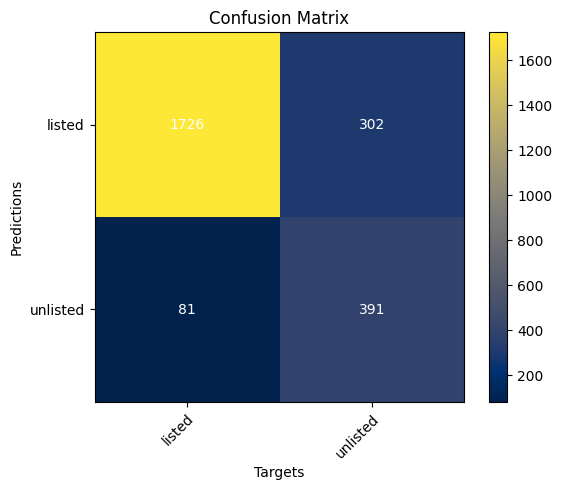

In [107]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(scale_pos_weight=0.3, random_state=123)
model_xgb.fit(X_train_ext, y_train)

# Predicting
y_pred = model_xgb.predict(X_val_ext)

# Evaluating
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())